<a name="h"></a>

#**Project:** &ensp; *MLP & CNN go &#128088; Fashion* &#128087;</font><br><br>

# **Purpose**
The purpose of this project is to get familiar with types of Deep Learning architectures. <br><br>

# **Task**
To build and implement 2 Deep Learning architectures (MLP & CNN) using a given dataset.<br><br>

---
<br><br>

[PART 0](#part0)
* [Libraries](#li)
* [Data Retrieval](#dr)
* [User-Defined Variables](#udv)

[PART A](#parta) (MLP Implementation)

[PART B](#partb) (CNN Implementation)
* [CNN_v1.0](#cnnv1) (Baseline)
* [CNN_v5](#cnnv5) (Tuned)

[PART C](#partc) (MLP - CNN Evaluation)
* [Support Functions](#evalsf)
* [MLP Evaluation](#mlpE)
* [CNN_v1.0 Evaluation](#cnnv1E) (Baseline)
* [CNN_v5 Evaluation](#cnnv5E) (Tuned)<br/><br/>

#### <u>References<u/>
* [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist)




<a name="part0"></a>
# <font color='green'>**PART 0**

<a name="li"></a>
>## Libraries  
🏠[Home](#h) &emsp;  🔼[Previous](#h)  &emsp;   🔽[Next](#dr)  



In [ ]:
!pip install -q -U tensorflow
!pip install -q -U visualkeras

In [ ]:
# general
import numpy as np
import random
import math
import time

import tensorflow as tf
import visualkeras as vis
from keras.regularizers import l2                                 # for CNN use
from tensorflow.keras.datasets import fashion_mnist               # dataset source
from tensorflow.keras.utils import to_categorical                 # labels to 1-hot vector
from sklearn.preprocessing import MinMaxScaler, StandardScaler    # scaling the data

# define network architecture
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dropout, Dense
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, BatchNormalization

# metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# graphics
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline, BSpline   # curvy lines

In [ ]:
# checking gpu if enable
tf.test.gpu_device_name()

''

<a name="dr"></a>
>## Data Retrieval
🏠[Home](#h) &emsp; 🔼[Previous](#li) &emsp; 🔽[Next](#udv)

In [ ]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [ ]:
print(f'Train Images Size: {train_images.shape}\t Form: {type(train_images)}\t Type of Data: {train_images.dtype}')
print(f'Train Labels Size: {train_labels.shape}\t\t Form: {type(train_labels)}\t Type of Data: {train_labels.dtype}')
print(f'Test Images Size : {test_images.shape}\t Form: {type(test_images)}\t Type of Data: {test_images.dtype}')
print(f'Test Labels Size : {test_labels.shape}\t\t Form: {type(test_labels)}\t Type of Data: {test_labels.dtype}')

Train Images Size: (60000, 28, 28)	 Form: <class 'numpy.ndarray'>	 Type of Data: uint8
Train Labels Size: (60000,)		 Form: <class 'numpy.ndarray'>	 Type of Data: uint8
Test Images Size : (10000, 28, 28)	 Form: <class 'numpy.ndarray'>	 Type of Data: uint8
Test Labels Size : (10000,)		 Form: <class 'numpy.ndarray'>	 Type of Data: uint8


<a name="udv"></a>
>## User-defined Variables
🏠[Home](#h) &emsp; 🔼[Previous](#dr) &emsp; 🔽[Next](#mlpdt)

In [ ]:
# the categories of our products in a dictionary for future use
category = {0 : 'T-shirt/top',
            1 : 'Trouser',
            2 : 'Pullover',
            3 : 'Dress',
            4 : 'Coat',
            5 : 'Sandal',
            6 : 'Shirt',
            7 : 'Sneaker',
            8 : 'Bag',
            9 : 'Ankle boot'}

np.random.seed(0)

# dimensions & channels
width, height, channels = train_images.shape[1], train_images.shape[2], 1

In [ ]:
def FreqPlot(t1, t2):
  '''
  USAGE:  to create and present the freq distribution of the train & test outputs
  TODO:
        1.  compute the frequencies
        2.  setup the workspace
        3.  create the barplots
        4.  present the plots to the user
  INPUT:
        t1 : the y_train
        t2 : the y_test
  OUTPUT:
        a bar plot presenting the distribution in train and test sets
  '''
  #******************************************************
  #******************** COUNTING ************************
  #******************************************************
  fig, ax = plt.subplots(1, 1, figsize=(10, 5))

  #------------------- train set ------------------------
  unique0, count0 = np.unique(t1, return_counts=True)

  #-------------------- test set ------------------------
  unique1, count1 = np.unique(t2, return_counts=True)

  #******************************************************
  #******************** PLOTING *************************
  #******************************************************
  X_axis = np.arange(len(unique0))

  #------------------- train set ------------------------
  ax.bar(X_axis, count0, color='r', label = 'Train')

  #-------------------- test set ------------------------
  ax.bar(X_axis, count1, bottom=count0, color='b', label = 'Test')

  #----------------- refining plot ----------------------
  plt.xticks(X_axis, category.values(), rotation=45)
  plt.xlabel("\nClasses", fontsize=14)
  plt.ylabel("Counts\n", fontsize=14)
  plt.title("Counts in each Class\n", fontsize=20)

  fig.legend(loc='outside right upper')
  plt.show()

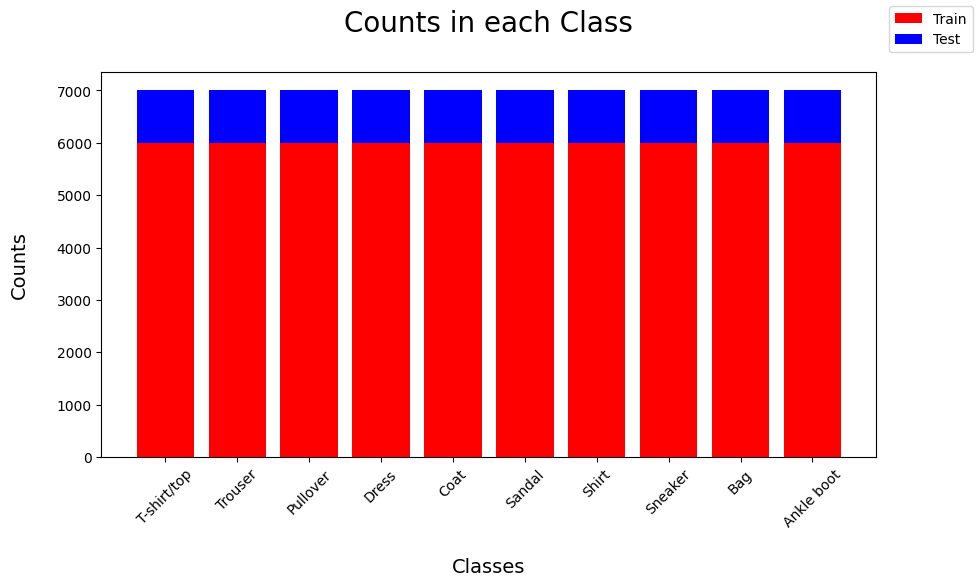

In [ ]:
# displaying the frequency of our dataset wrt train & test sets
FreqPlot(train_labels, test_labels)

As we can observe, `the dataset is balanced`

<a name="parta"></a>
# <font color='orange'>**PART A**</font> (MLP Implementation)
🏠[Home](#h) &emsp; 🔼[Previous](#udv) &emsp; 🔽[Next](#cnnv1)

<a name="mlpdt"></a>
>## Data Tranformation


>>### Reshaping the Data

In [ ]:
# Reshaping the images from 28x28 to 1-vector 1x784 each record
x_train = np.reshape(train_images.copy(), (-1, width * height))
# tranforming ground truth to 1-hot vector for each record
y_train_1_hot = to_categorical(train_labels.copy())

x_test = np.reshape(test_images.copy(), (-1, width * height))
y_test_1_hot = to_categorical(test_labels.copy())

In [ ]:
print(f'Reshaped Train Images Size : {x_train.shape}\t Form: {type(x_train)}\t Type of Data: {x_train.dtype}')
print(f'1-hot Train Labels Size    : {y_train_1_hot.shape}\t Form: {type(y_train_1_hot)}\t Type of Data: {y_train_1_hot.dtype}\n')

print(f'Reshaped Test Images Size  : {x_test.shape}\t Form: {type(x_test)}\t Type of Data: {x_test.dtype}')
print(f'1-hot Test Labels Size     : {y_test_1_hot.shape}\t Form: {type(y_test_1_hot)}\t Type of Data: {y_test_1_hot.dtype}')

Reshaped Train Images Size : (60000, 784)	 Form: <class 'numpy.ndarray'>	 Type of Data: uint8
1-hot Train Labels Size    : (60000, 10)	 Form: <class 'numpy.ndarray'>	 Type of Data: float32

Reshaped Test Images Size  : (10000, 784)	 Form: <class 'numpy.ndarray'>	 Type of Data: uint8
1-hot Test Labels Size     : (10000, 10)	 Form: <class 'numpy.ndarray'>	 Type of Data: float32


In [ ]:
# 1-hot label sample
y_test_1_hot[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.], dtype=float32)

>>### Data Normalization

In [ ]:
print(f'Min, Max values of images\' pixels:\tMinVal: {np.min(train_images)}\tMaxVal:{np.max(train_images)}')

Min, Max values of images' pixels:	MinVal: 0	MaxVal:255


The pixels' values are between 0 and 255, so it's a good practice to normalize these values and limit them between [0, 1].

In [ ]:
scaler = MinMaxScaler()

x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)

<a name="mlpf"></a>
>## Formulation


In [ ]:
input_shape = x_train[0].shape

In [ ]:
# MLP formulation
mlp = Sequential()
mlp.add(InputLayer(input_shape=input_shape))    # input layer
mlp.add(Dense(256, activation='relu'))          # hidden layer 1
mlp.add(Dropout(0.2))
mlp.add(Dense(256, activation='relu'))          # hidden layer 2
mlp.add(Dropout(0.2))
mlp.add(Dense(128, activation='relu'))          # hidden layer 3
mlp.add(Dropout(0.25))
mlp.add(Dense(10, activation='softmax'))        # output layer

# summary
mlp.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               200960    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 10)                1

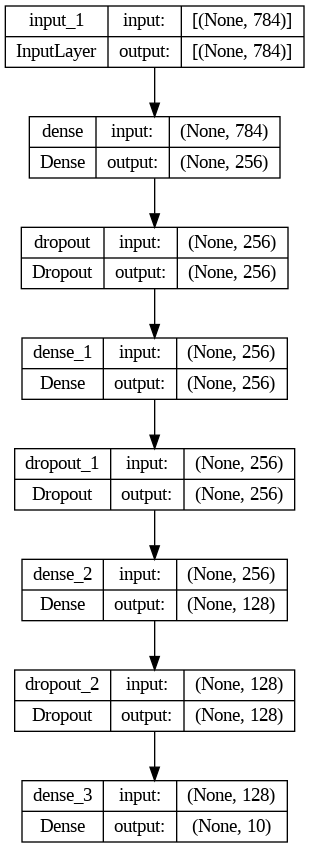

In [ ]:
tf.keras.utils.plot_model(mlp, show_shapes=True)

<a name="mlpc"></a>
>## Compilation
<!-- 🏠[Home](#h) &emsp; 🔼[Previous](#mlpf) &emsp; 🔽[Next](#mlpF) -->

In [ ]:
# optimization
mlp.compile(loss='categorical_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])

<a name="mlpF"></a>
>## Fitting
<!-- 🏠[Home](#h) &emsp; 🔼[Previous](#mlpc) &emsp; 🔽[Next](#mlpP) -->

In [ ]:
# fitting the train set
history_mlp = mlp.fit(x_train, y_train_1_hot,
                  epochs=20, batch_size=128, validation_split = 0.2)

Epoch 1/20
375/375 [==============================] - 8s 6ms/step - loss: 0.6318 - accuracy: 0.7742 - val_loss: 0.4341 - val_accuracy: 0.8394
Epoch 2/20
375/375 [==============================] - 2s 4ms/step - loss: 0.4336 - accuracy: 0.8451 - val_loss: 0.3966 - val_accuracy: 0.8581
Epoch 3/20
375/375 [==============================] - 2s 4ms/step - loss: 0.3913 - accuracy: 0.8588 - val_loss: 0.3686 - val_accuracy: 0.8670
Epoch 4/20
375/375 [==============================] - 2s 4ms/step - loss: 0.3667 - accuracy: 0.8683 - val_loss: 0.3523 - val_accuracy: 0.8712
Epoch 5/20
375/375 [==============================] - 1s 4ms/step - loss: 0.3456 - accuracy: 0.8738 - val_loss: 0.3448 - val_accuracy: 0.8739
Epoch 6/20
375/375 [==============================] - 1s 4ms/step - loss: 0.3312 - accuracy: 0.8787 - val_loss: 0.3348 - val_accuracy: 0.8786
Epoch 7/20
375/375 [==============================] - 2s 4ms/step - loss: 0.3201 - accuracy: 0.8830 - val_loss: 0.3299 - val_accuracy: 0.8806
Epoch 

>## Predicting


In [ ]:
# predictions for the test set
pred_mlp = np.array(list(map(lambda x: np.argmax(x), mlp.predict(x_test, verbose=0))))

In [ ]:
def makePrediction(idx, predictions):
  '''
  USAGE : to make a prediction given an index of an image
  TODO  :
          1.  find the image in the test set using the given index
          2.  find the label of the image using the index
          3.  find the prediction for this image using the index
          4.  make a logical operation if what's found is correct or not
          5.  plot the image and the findings
  INPUT :
          idx : the index of the image
          predictions : the predictions we've made over the test set
  OUTPUT:
          None
  '''
  img = test_images[idx]
  label = test_labels[idx]
  pred = predictions[idx]

  if pred == label:
    logic = 'Correct'
  else:
    logic = 'False'

  plt.imshow(img, cmap='binary')
  plt.title(f'Category: [{label}] {category[label]}\nPrediction: [{pred}] {logic}')
  plt.grid(visible=False)

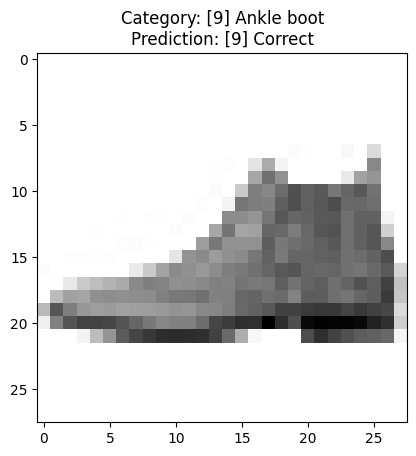

In [ ]:
makePrediction(0, pred_mlp)

<a name="partb"></a>
# <font color=#5da8f1>**PART B**</font> (CNN Implementation)

<a name="cnnv1"></a>
>## CNN_v1.0
🏠[Home](#h) &emsp; 🔼[Previous](#parta) &emsp; 🔽[Next](#cnnv5)

<a name="cnndt"></a>
>>### Data Transformation


In [ ]:
X_train, X_test = train_images.copy()/255, test_images.copy()/255

In [ ]:
# Reshaping the train & test sets to the shape that our model expects when we train the model
X_train = np.reshape(X_train, (X_train.shape[0], width, height, channels))
X_test = np.reshape(X_test, (X_test.shape[0], width, height, channels))

In [ ]:
print(f'Reshaped Train Set : {X_train.shape}\t Form: {type(X_train)}\t Type of Data: {X_train.dtype}')
print(f'Reshaped Train Set : {X_test.shape}\t Form: {type(X_test)}\t Type of Data: {X_test.dtype}')

Reshaped Train Set : (60000, 28, 28, 1)	 Form: <class 'numpy.ndarray'>	 Type of Data: float64
Reshaped Train Set : (10000, 28, 28, 1)	 Form: <class 'numpy.ndarray'>	 Type of Data: float64


<a name="cnnf"></a>
>>### Formulation


In [ ]:
input_shape_cnn = (width, height, channels)

In [ ]:
#create model
cnn = Sequential()

#add layers to cnn
cnn.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=input_shape_cnn))  # input layer
cnn.add(MaxPooling2D((2, 2)))                                                       # max pulling
cnn.add(Conv2D(64, kernel_size=3, activation='relu'))                               # conv2d layer
cnn.add(MaxPooling2D((2, 2)))                                                       # max pulling
cnn.add(Flatten())                                                                  # flatten
cnn.add(Dense(64, activation='relu'))                                               # mlp
cnn.add(Dense(10, activation='softmax'))                                            # output layer

# summary
cnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dense_7 (Dense)             (None, 64)               

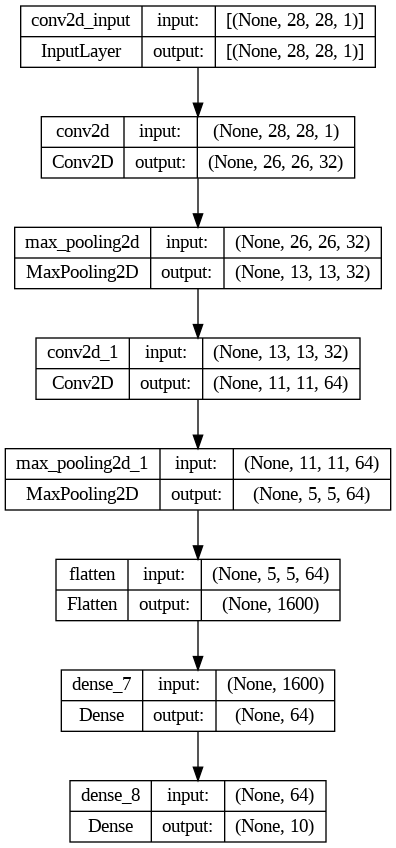

In [ ]:
tf.keras.utils.plot_model(cnn, show_shapes=True)

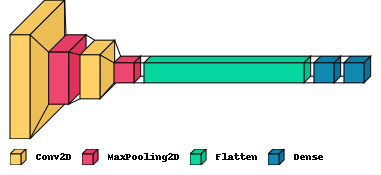

In [ ]:
vis.layered_view(cnn,legend=True)

<a name="cnnc"></a>
>>### Compilation


In [ ]:
#compile model using accuracy to measure model performance
cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

<a name="cnnF"></a>
>>### Fitting


In [ ]:
#train the model
history_cnn = cnn.fit(X_train, y_train_1_hot, validation_split = 0.2, epochs=20, batch_size=128)

Epoch 1/20
375/375 [==============================] - 9s 6ms/step - loss: 0.6366 - accuracy: 0.7701 - val_loss: 0.4289 - val_accuracy: 0.8469
Epoch 2/20
375/375 [==============================] - 2s 5ms/step - loss: 0.3982 - accuracy: 0.8564 - val_loss: 0.3708 - val_accuracy: 0.8713
Epoch 3/20
375/375 [==============================] - 2s 5ms/step - loss: 0.3420 - accuracy: 0.8776 - val_loss: 0.3327 - val_accuracy: 0.8799
Epoch 4/20
375/375 [==============================] - 2s 5ms/step - loss: 0.3077 - accuracy: 0.8879 - val_loss: 0.3069 - val_accuracy: 0.8905
Epoch 5/20
375/375 [==============================] - 2s 5ms/step - loss: 0.2811 - accuracy: 0.8969 - val_loss: 0.3037 - val_accuracy: 0.8932
Epoch 6/20
375/375 [==============================] - 2s 5ms/step - loss: 0.2625 - accuracy: 0.9038 - val_loss: 0.2760 - val_accuracy: 0.8979
Epoch 7/20
375/375 [==============================] - 2s 6ms/step - loss: 0.2452 - accuracy: 0.9099 - val_loss: 0.2740 - val_accuracy: 0.9019
Epoch 

<a name="cnnP"></a>
>>### Predicting


In [ ]:
# predictions for the test set
pred_cnn = np.array(list(map(lambda x: np.argmax(x), cnn.predict(X_test, verbose=0))))

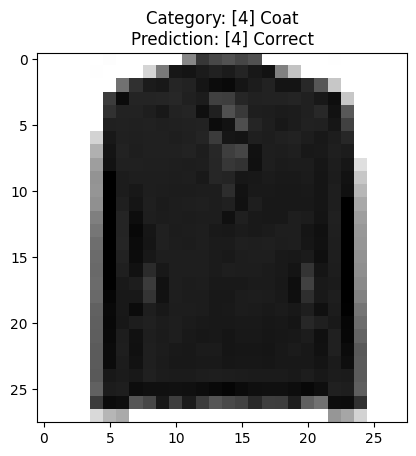

In [ ]:
makePrediction(994, pred_cnn)

<a name="cnnv5"></a>
>## CNN_v5 (Tuned) Implementation
🏠[Home](#h) &emsp; 🔼[Previous](#cnnv1) &emsp; 🔽[Next](#partc)

<a name="cnnf"></a>
>>### Formulation

In [ ]:
#create model
cnn5 = Sequential()

#>>>>> cnn layers
cnn5.add(Conv2D(256, kernel_size=3, padding='same', activation='relu', input_shape=input_shape_cnn))
cnn5.add(BatchNormalization())
cnn5.add(MaxPooling2D((2, 2)))
cnn5.add(Dropout(0.25))
cnn5.add(Conv2D(128, kernel_size=3, padding='same', activation='relu', kernel_regularizer=l2(0.0001))) # l2 --> [0.0001, 0.001] helps with overfitting
cnn5.add(BatchNormalization())
cnn5.add(MaxPooling2D((2, 2)))
cnn5.add(Dropout(0.25))
cnn5.add(Conv2D(128, kernel_size=3, padding='same', activation='relu', kernel_regularizer=l2(0.0001))) # l2 --> [0.0001, 0.001] helps with overfitting
cnn5.add(BatchNormalization())
cnn5.add(MaxPooling2D((2, 2)))
cnn5.add(Dropout(0.25))

#>>>>> flatline
cnn5.add(Flatten())

#>>>>> mlp layers
cnn5.add(Dense(512, activation='relu'))
cnn5.add(BatchNormalization())
cnn5.add(Dropout(0.3))

#>>>>> output
cnn5.add(Dense(10, activation='softmax'))

# summary
cnn5.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 28, 28, 256)       2560      
                                                                 
 batch_normalization_4 (Batc  (None, 28, 28, 256)      1024      
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 256)      0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 14, 14, 256)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 128)       295040    
                                                                 
 batch_normalization_5 (Batc  (None, 14, 14, 128)     

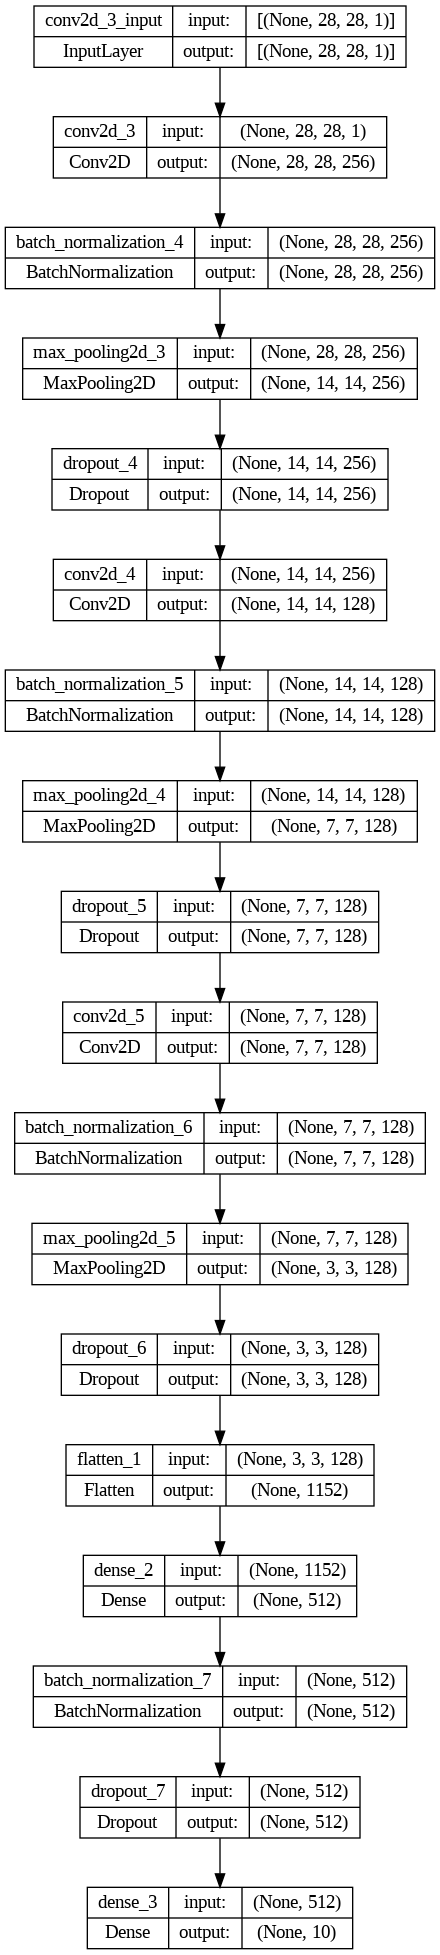

In [ ]:
tf.keras.utils.plot_model(cnn5, show_shapes=True)

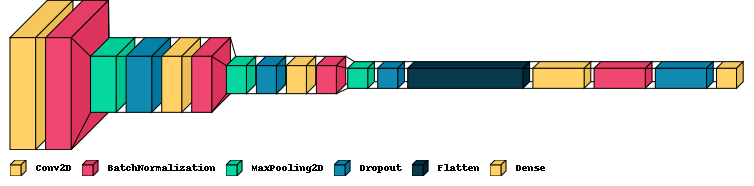

In [ ]:
vis.layered_view(cnn5,legend=True)

<a name="cnnc"></a>
>>### Compilation

In [ ]:
train_steps5 = 5000
lr_fn5 = tf.optimizers.schedules.PolynomialDecay(1e-3, train_steps5, 1e-5, 2)
opt5 = tf.optimizers.Adam(lr_fn5)

#compile model using accuracy to measure model performance
cnn5.compile(optimizer=opt5, loss='categorical_crossentropy', metrics=['accuracy'])

<a name="cnnF"></a>
>>### Fitting


In [ ]:
#train the model
history_cnn5 = cnn5.fit(X_train, y_train_1_hot, validation_split = 0.1, epochs=20, batch_size=64)

Epoch 1/20
844/844 [==============================] - 604s 713ms/step - loss: 0.5317 - accuracy: 0.8239 - val_loss: 0.3467 - val_accuracy: 0.8775
Epoch 2/20
844/844 [==============================] - 603s 714ms/step - loss: 0.3494 - accuracy: 0.8871 - val_loss: 0.2902 - val_accuracy: 0.9077
Epoch 3/20
844/844 [==============================] - 605s 717ms/step - loss: 0.3015 - accuracy: 0.9039 - val_loss: 0.2542 - val_accuracy: 0.9197
Epoch 4/20
844/844 [==============================] - 602s 713ms/step - loss: 0.2661 - accuracy: 0.9150 - val_loss: 0.2534 - val_accuracy: 0.9200
Epoch 5/20
844/844 [==============================] - 606s 718ms/step - loss: 0.2437 - accuracy: 0.9236 - val_loss: 0.2340 - val_accuracy: 0.9273
Epoch 6/20
844/844 [==============================] - 601s 712ms/step - loss: 0.2321 - accuracy: 0.9293 - val_loss: 0.2338 - val_accuracy: 0.9270
Epoch 7/20
844/844 [==============================] - 605s 717ms/step - loss: 0.2288 - accuracy: 0.9288 - val_loss: 0.2320 -

<a name="cnnP"></a>
>>### Predicting

In [ ]:
# predictions for the test set
pred_cnn5 = np.array(list(map(lambda x: np.argmax(x), cnn5.predict(X_test, verbose=0))))

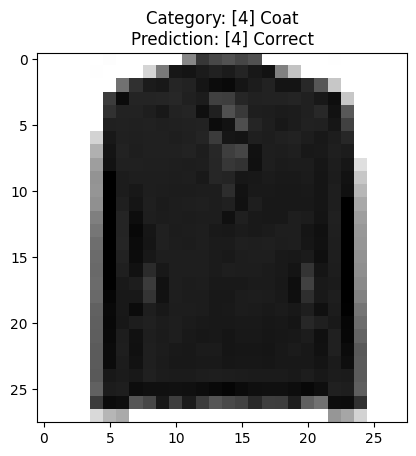

In [ ]:
makePrediction(994, pred_cnn5)

<a name="partc"></a>
# <font color='red'>**PART C**</font> (MLP - CNN Evaluation)
🏠[Home](#h) &emsp; 🔼[Previous](#cnnv4) &emsp; 🔽[Next](#mlpE)

<a name="evalsf"></a>
>## Support Functions
<!-- 🏠[Home](#h) &emsp; 🔼[Previous](#cnnP) &emsp; 🔽[Next](#mlpE) -->

In [ ]:
def classificationReport(labels, predictions, model):
  '''
  USAGE :     compute & print-out the cllasification report of a model
  TODO  :
          1.  build the classification report
          2.  print the findings
  INPUT :
          labels  : the ground truth for the test set images
          predictions : the predictions we've made over the test set
          model : the model we're using
  OUTPUT:
          None
  '''
  print(f'Classification Report of {model}\n')
  # displaying the classification report for the MLP
  cr = classification_report(labels, predictions, target_names=category.values())
  print(cr)

In [ ]:
def plotConfMatrix(labels, predictions, model):
  '''
  USAGE : to plot the confusion matrix for a given model
  TODO  :
          1.  compute the confusion matrix
          2.  plot the matrix
  INPUT :
          labels  : the ground truth for the test set images
          predictions : the predictions we've made over the test set
          model : the model we're using
  OUTPUT:
          None
  '''
  # confusion matrix for the given model
  cm = confusion_matrix(labels, predictions, normalize='true')
  disp = ConfusionMatrixDisplay(cm, display_labels=category.values())

  # adjusting and formating the confusion matrix plot
  fig, ax = plt.subplots(figsize=(10,10))
  disp.plot(ax=ax, xticks_rotation=45, colorbar=False)
  cax = fig.add_axes([ax.get_position().x1+0.01, ax.get_position().y0, 0.02, ax.get_position().height])
  plt.colorbar(disp.im_,  cax=cax)
  ax.set_xlabel('\nPredicted Label',fontsize=15)
  ax.set_ylabel('True Label\n',fontsize=15)
  ax.set_title(f'Confusion Matrix for {model}\n', fontsize=20)
  ax.grid(visible=False)
  plt.show()

In [ ]:
def evalPerf(model, xtest, ytest):
  '''
  USAGE : to evaluate the performance of a given model
  TODO  :
          1.  evaluate the performance
          2.  print-out accuracy & loss metrics
  INPUT :
          labels  : the ground truth for the test set images
          predictions : the predictions we've made over the test set
          model : the model we're using
  OUTPUT:
          None
  '''
  # evaluate performance
  loss, acc = model.evaluate(xtest, ytest, batch_size=128, verbose=0)

  print(f'Test loss: {loss:.4f}')
  print(f'Test accuracy: {acc:.4f}')

In [ ]:
def plotCurves(history, model):
  '''
  USAGE :  to present the loss & accuracy curves wrt epochs the model has trained
  TODO  :
          1.  create smooth curves
          2.  plot the curves
  INPUT :
          history: the history we get during fitting process
          model:  the model we're investigating
  OUTPUT:
          None
  '''
  ts = np.linspace(0, 20, 100)

  # plotting space configuration
  fig, axs = plt.subplots(1, 2, figsize=(15, 5))

  #-------------------------------------- accuracy -------------------------------------
  spl_acc_train = make_interp_spline(range(20), history.history['accuracy'], k=2)
  y_smooth_acc_train = spl_acc_train(ts)

  spl_acc_val = make_interp_spline(range(20), history.history['val_accuracy'], k=2)
  y_smooth_acc_val = spl_acc_val(ts)

  axs[0].plot(ts, y_smooth_acc_train)
  axs[0].plot(ts, y_smooth_acc_val)

  axs[0].set_title(f'{model} Accuracy wrt Epochs Trained\n', fontsize = 20)
  axs[0].set_ylabel('Accuracy\n', fontsize = 15)
  axs[0].set_xlabel('\nEpoch', fontsize = 15)
  axs[0].legend(['Train', 'Val'], loc='lower right')
  axs[0].set_yticks(np.arange(0, 1.1, 0.1))
  axs[0].set_xticks(range(0,21, 5))

  #--------------------------------------- loss ----------------------------------------
  spl_loss_train = make_interp_spline(range(20), history.history['loss'], k=2)
  y_smooth_loss_train = spl_loss_train(ts)

  spl_loss_val = make_interp_spline(range(20), history.history['val_loss'], k=2)
  y_smooth_loss_val = spl_loss_val(ts)

  axs[1].plot(ts, y_smooth_loss_train)
  axs[1].plot(ts, y_smooth_loss_val)

  axs[1].set_title(f'{model} Loss wrt Epochs Trained\n', fontsize = 20)
  axs[1].set_ylabel('Loss\n', fontsize = 15)
  axs[1].set_xlabel('\nEpoch', fontsize = 15)
  axs[1].legend(['Train', 'Val'], loc='best')
  axs[1].set_yticks(np.arange(0, 1.1, 0.1))
  axs[1].set_xticks(range(0,21, 5))

  fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=None)
  plt.ylim(top=1)

  plt.show()

<a name="mlpE"></a>
>## MLP Evaluation
🏠[Home](#h) &emsp; 🔼[Previous](#partc) &emsp; 🔽[Next](#cnnv1E)

In [ ]:
classificationReport(test_labels, pred_mlp, 'MLP')

Classification Report of MLP

              precision    recall  f1-score   support

 T-shirt/top       0.86      0.83      0.85      1000
     Trouser       0.97      0.98      0.98      1000
    Pullover       0.80      0.81      0.80      1000
       Dress       0.90      0.87      0.88      1000
        Coat       0.77      0.85      0.81      1000
      Sandal       0.97      0.96      0.97      1000
       Shirt       0.72      0.69      0.70      1000
     Sneaker       0.94      0.96      0.95      1000
         Bag       0.98      0.97      0.98      1000
  Ankle boot       0.96      0.95      0.96      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



In [ ]:
evalPerf(mlp, x_test, y_test_1_hot)

Test loss: 0.3291
Test accuracy: 0.8871


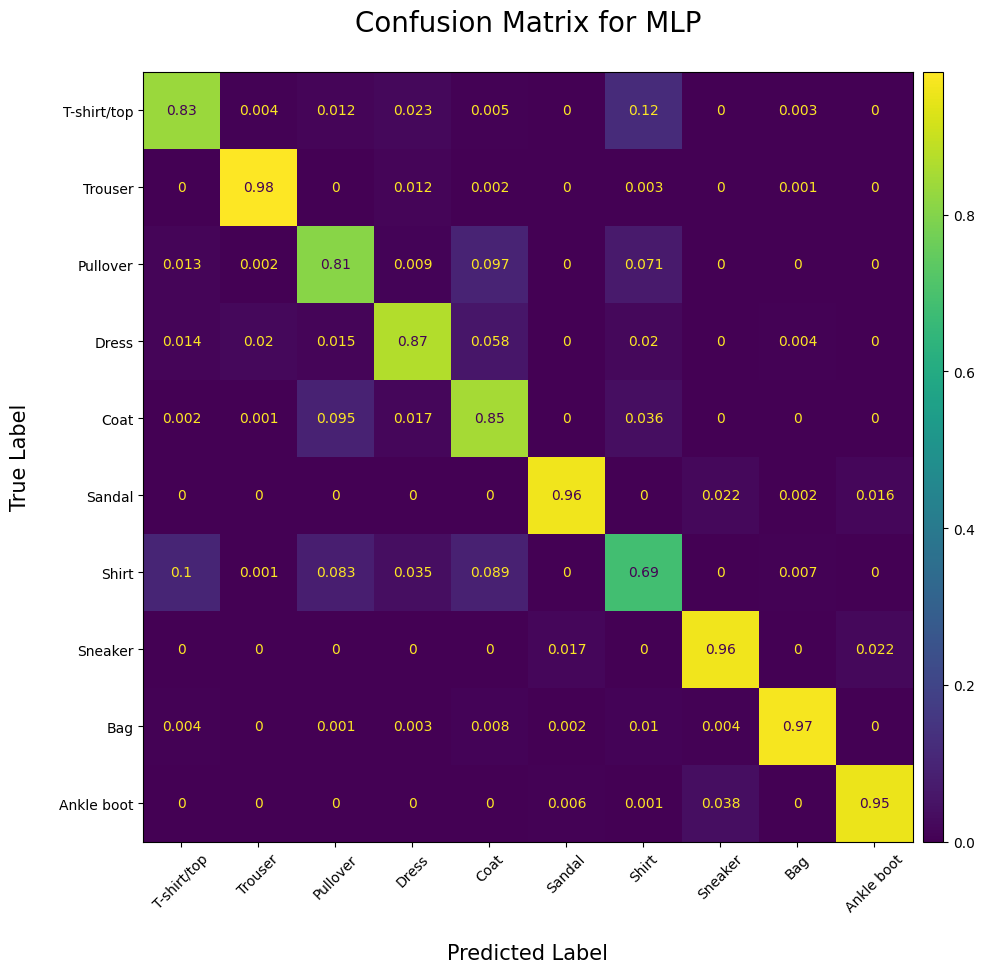

In [ ]:
plotConfMatrix(test_labels, pred_mlp, 'MLP')

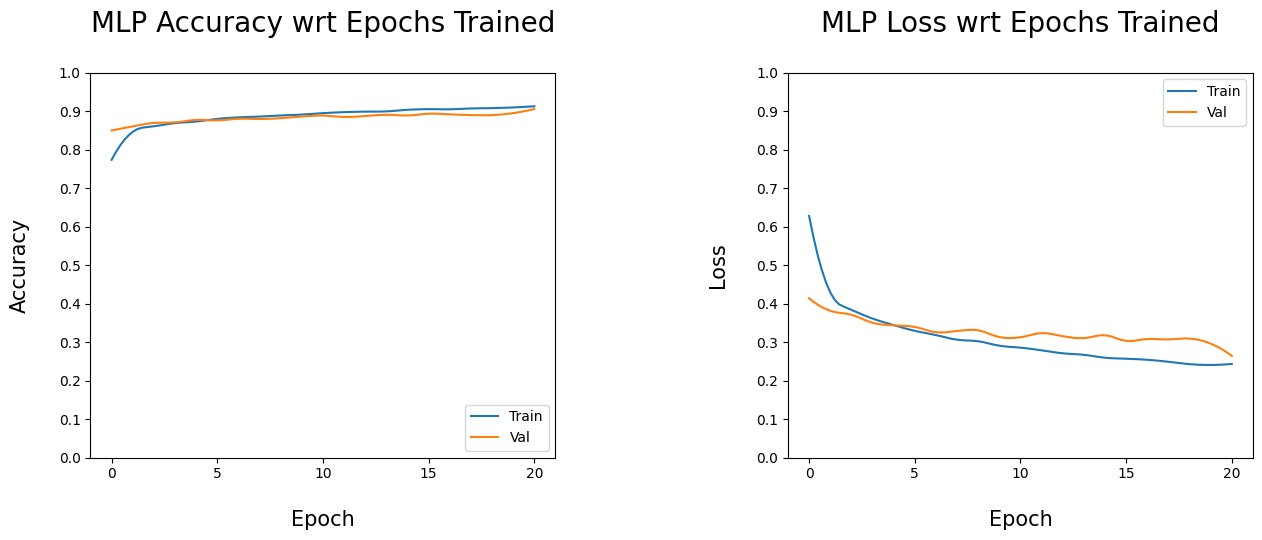

In [ ]:
plotCurves(history_mlp, 'MLP')

<a name="cnnv1E"></a>
>## CNN_v1.0 Evaluation
🏠[Home](#h) &emsp; 🔼[Previous](#mlpE) &emsp; 🔽[Next](#cnnv5E)

In [ ]:
classificationReport(test_labels, pred_cnn, 'CNN_v1.0')

Classification Report of CNN_v1.0

              precision    recall  f1-score   support

 T-shirt/top       0.88      0.83      0.85      1000
     Trouser       1.00      0.98      0.99      1000
    Pullover       0.84      0.89      0.86      1000
       Dress       0.90      0.93      0.91      1000
        Coat       0.84      0.87      0.85      1000
      Sandal       0.98      0.97      0.98      1000
       Shirt       0.76      0.72      0.74      1000
     Sneaker       0.94      0.97      0.96      1000
         Bag       0.97      0.98      0.98      1000
  Ankle boot       0.98      0.95      0.97      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



In [ ]:
evalPerf(cnn, X_test, y_test_1_hot)

Test loss: 0.2914
Test accuracy: 0.9084


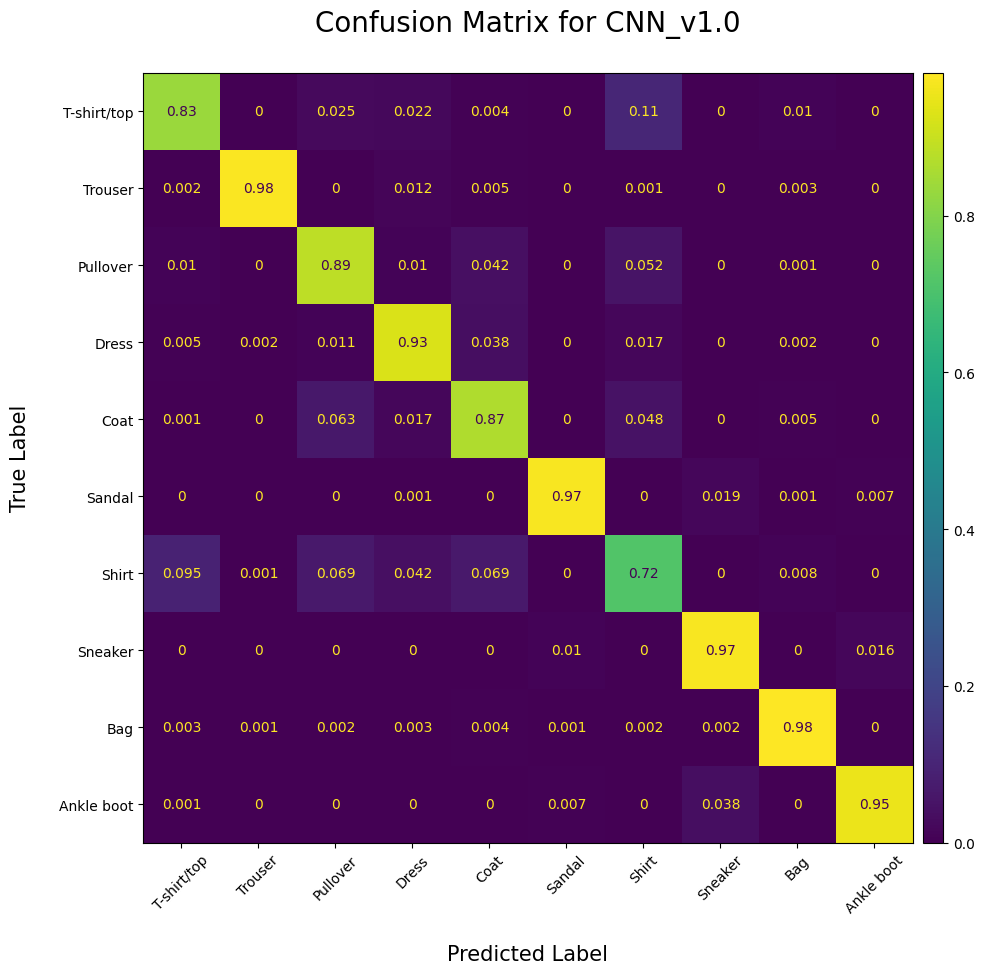

In [ ]:
plotConfMatrix(test_labels, pred_cnn, 'CNN_v1.0')

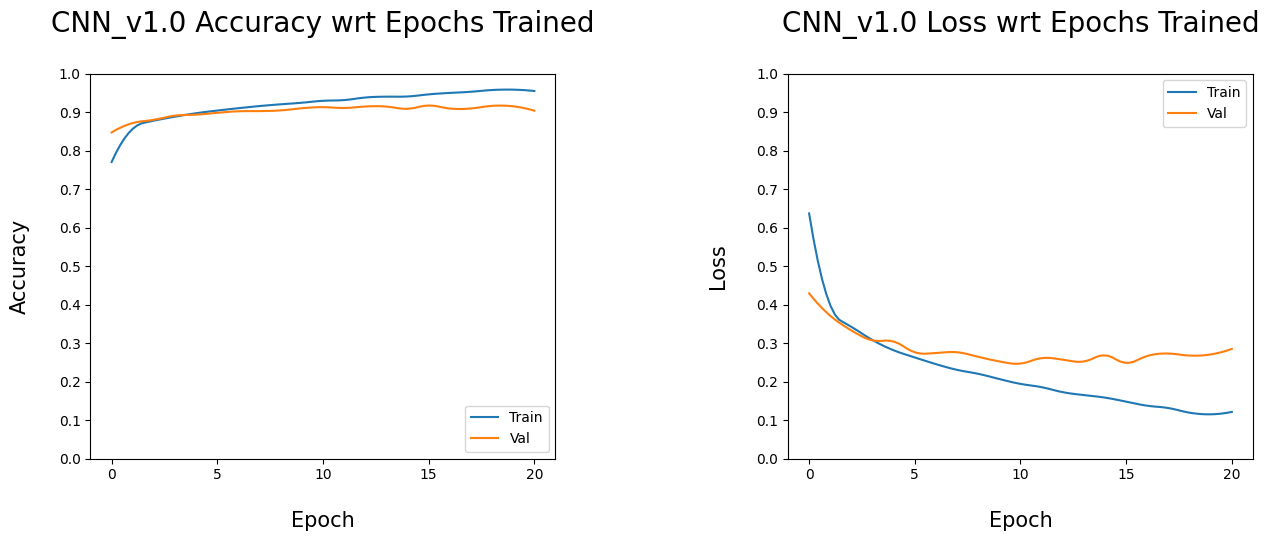

In [ ]:
plotCurves(history_cnn, 'CNN_v1.0')

<a name="cnnv5E"></a>
>## CNN_v5 (Tuned) Evaluation
🏠[Home](#h) &emsp; 🔼[Previous](#cnnv1E)

In [ ]:
classificationReport(test_labels, pred_cnn5, 'CNN_v5')

Classification Report of CNN_v5

              precision    recall  f1-score   support

 T-shirt/top       0.90      0.86      0.88      1000
     Trouser       0.99      0.99      0.99      1000
    Pullover       0.92      0.88      0.90      1000
       Dress       0.93      0.93      0.93      1000
        Coat       0.87      0.90      0.89      1000
      Sandal       0.99      0.98      0.98      1000
       Shirt       0.77      0.80      0.78      1000
     Sneaker       0.95      0.98      0.97      1000
         Bag       0.99      0.99      0.99      1000
  Ankle boot       0.98      0.96      0.97      1000

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



In [ ]:
evalPerf(cnn5, X_test, y_test_1_hot)

Test loss: 0.2375
Test accuracy: 0.9275


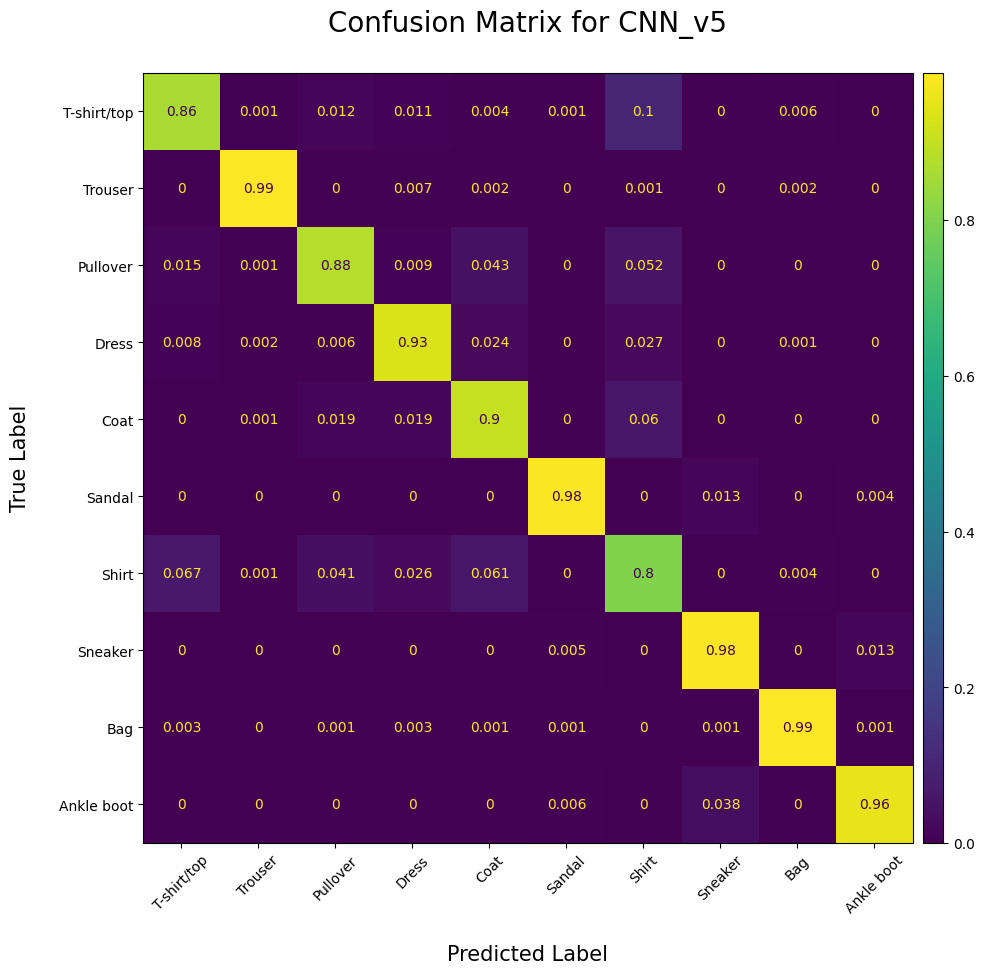

In [ ]:
plotConfMatrix(test_labels, pred_cnn5, 'CNN_v5')

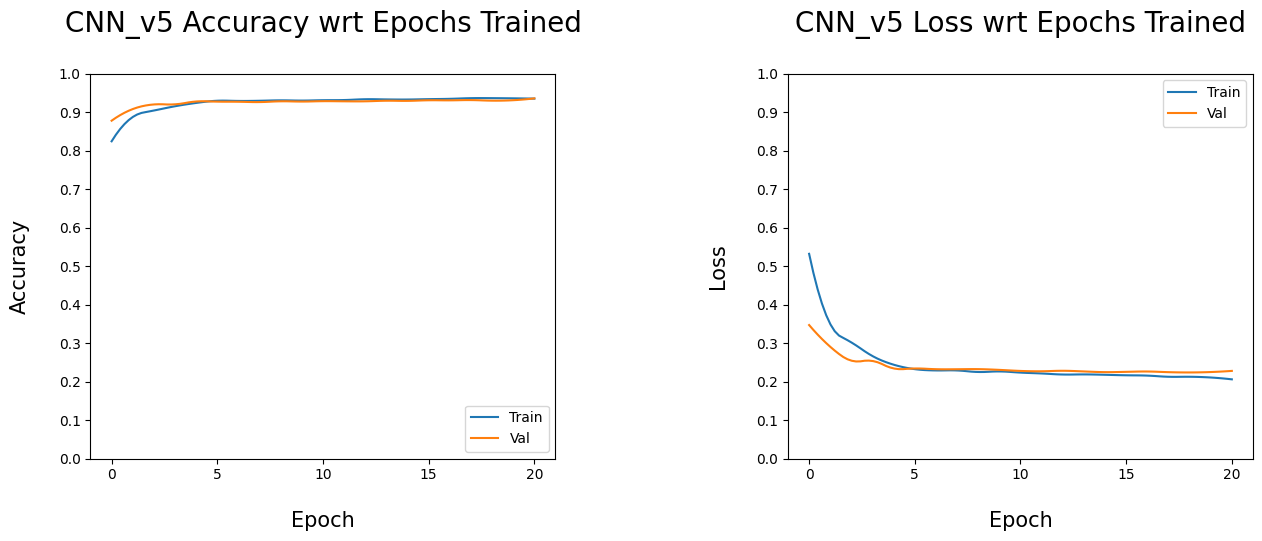

In [ ]:
plotCurves(history_cnn5, 'CNN_v5')

We can observe that the `CNN performs better than the MLP`; we haven't attempted any tuning to the MLP model though.